In [0]:
import os
os.chdir("./Temp")

In [0]:
from preprocessing import *
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

matplotlib.rcParams['figure.figsize'] = [15,5]

data_contrats = pd.read_csv('train_contrats.csv',sep=";", engine="python")
data_contrats["Freq_sinistre"] = data_contrats["nombre_de_sinistre"]/data_contrats["Exposition_au_risque"]

In [16]:
df = preprocessing(data_contrats, balance=False, train_size=1)[0]
#df = df[:10000]
X = df.drop("Freq_sinistre", axis=1, inplace=False).to_numpy()
Y = np.array(df["Freq_sinistre"])

/content/Temp/preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering["Classe_Age_Situ_Cont"]=data_clustering["Classe_Age_Situ_Cont"].apply(classe_age)
/content/Temp/preprocessing.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering["franchise"]=data_clustering["franchise"].apply(franchise_)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [17]:
df

,Classe_Age_Situ_Cont,franchise,Exposition_au_risque,ValeurPuissance,Freq_sinistre,Type_Apporteur_1,Type_Apporteur_2,Type_Apporteur_3,Activite_1,Activite_2,Activite_3,Activite_4,Activite_5,Activite_6,Activite_7,Activite_8,Mode_gestion_N,Mode_gestion_P,Zone_1,Zone_2,Zone_3,Zone_4,Zone_5,Zone_6,Fractionnement_A,Fractionnement_S,Fractionnement_T,FORMULE_2,FORMULE_3,FORMULE_4,FORMULE_5,Age_du_vehicule_<= 5 ans,Age_du_vehicule_> 5 ans
0,0.596130,0.298065,0.054645,0.695485,0.0,0.099355,0.000000,0.0,0.0,0.0,0.099355,0.0,0.0,0.000000,0.000000,0.0,0.099355,0.0,0.0,0.000000,0.0,0.099355,0.0,0.0,0.099355,0.000000,0.000000,0.0,0.000000,0.0,0.099355,0.099355,0.000000
1,0.541791,0.216716,0.044427,0.758507,0.0,0.000000,0.108358,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.108358,0.0,0.108358,0.0,0.0,0.000000,0.0,0.108358,0.0,0.0,0.000000,0.108358,0.000000,0.0,0.108358,0.0,0.000000,0.000000,0.108358
2,0.542157,0.216863,0.024939,0.759020,0.0,0.000000,0.108431,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.108431,0.0,0.108431,0.0,0.0,0.000000,0.0,0.108431,0.0,0.0,0.000000,0.108431,0.000000,0.0,0.108431,0.0,0.000000,0.000000,0.108431
3,0.692925,0.277170,0.036032,0.554340,0.0,0.000000,0.138585,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.138585,0.0,0.138585,0.0,0.0,0.000000,0.0,0.138585,0.0,0.0,0.000000,0.138585,0.000000,0.0,0.000000,0.0,0.138585,0.138585,0.000000
4,0.755584,0.251861,0.030223,0.503722,0.0,0.000000,0.125931,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.125931,0.0,0.125931,0.0,0.0,0.000000,0.0,0.125931,0.0,0.0,0.000000,0.125931,0.000000,0.0,0.000000,0.0,0.125931,0.125931,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87223,0.612123,0.204041,0.028566,0.714143,0.0,0.102020,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.102020,0.000000,0.0,0.102020,0.0,0.0,0.102020,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.102020,0.0,0.102020,0.0,0.000000,0.102020,0.000000
87224,0.612123,0.204041,0.028566,0.714143,0.0,0.102020,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.102020,0.000000,0.0,0.102020,0.0,0.0,0.102020,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.102020,0.0,0.102020,0.0,0.000000,0.102020,0.000000
87225,0.612291,0.204097,0.016328,0.714339,0.0,0.102048,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.102048,0.000000,0.0,0.102048,0.0,0.0,0.102048,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.102048,0.0,0.102048,0.0,0.000000,0.000000,0.102048
87226,0.612123,0.204041,0.028566,0.714143,0.0,0.102020,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.102020,0.000000,0.0,0.102020,0.0,0.0,0.102020,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.102020,0.0,0.102020,0.0,0.000000,0.102020,0.000000


In [0]:
df_drop = df.drop("Freq_sinistre", axis=1)
tree = KDTree(df_drop.values)

In [0]:
def approx(df_drop, y, i, dist, ind, var):
    """
    Approximates the value of Freq_sinistre for row i 
    """
    delta_y = (y-y[i])[ind]
    gauss_weights = np.exp(-dist / var)
    y_hat = max(y[i]+ np.dot(delta_y, gauss_weights),0)
    return y_hat

Pour les 80000 points du jeu de données, il faut donc compter près de 400 secondes. Cela reste raisonnable. Toutefois, pour trouver la bonne valeur de la variance, il faudra faire cela plusieurs fois ce qui peut prendre du temps. On va commencer par selectionner les 1000 voisins les plus proches situés à une distance inférieure ou égale à 0.25.

In [0]:
def approx_freq(df, thresh, k, var):
    """
    approximates the Freq_sinisre column and inflate zeros
    
    parameters :
    thresh : part of the space points to select (maximum distance between a point and one of the selected neighbour)
    k : first neighbours to search in KDTree. This may affect computationnal time.
    var : vairance of the gaussian distance
    """
    Y_hat = []
    Y = df["Freq_sinistre"].values
    N=[]
    for i in range(len(df)):
        #if i % 10000 == 0:
        #    print(i)
        features = df_drop.iloc[i]
        # select k nearest neigbours
        dist, ind = tree.query(features.values.reshape(1, -1), k=k)
        # select only those not too far (to be discussed)
        n = np.sum(dist<thresh)
        dist = dist[0][:n]
        ind = ind[0][:n]
        N.append(n)
        y_hat = approx(df_drop, Y, i, dist, ind, var)
        Y_hat.append(y_hat)
    df_copy = df.copy()
    df_copy["Freq_sinistre"] = Y_hat
    return df_copy
    

In [22]:
thresh = 0.25
k=1000
var=np.exp(-5)
df_approx = approx_freq(df, thresh, k, var)

0
10000
20000
30000
40000
50000
60000
70000
80000



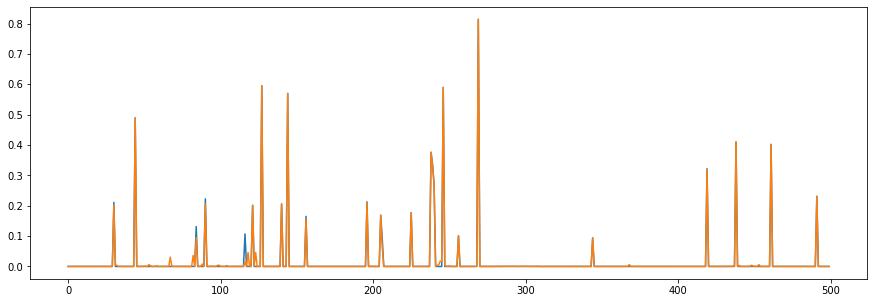

In [23]:
plt.plot(range(500),df.Freq_sinistre[:500])
plt.plot(range(500),df_approx.Freq_sinistre[:500])

In [24]:
count_zeros(df_approx["Freq_sinistre"],10**(-6))

0.8036524969046637

#### Optimisation de la variance

Les bornes n'ont pas été trouvées directement. A partir de exp(-5), plusieurs valeurs ont été testées pour trouver un intervalle qui contiennent les plateaux "hauts et bas" pour les deux mesures : nombre de zéros et erreur quadratique. Nous savions que la premiere serait décroissante en fonction de la variance, et l'autre croissante. Nous avons ainsi esayer d'avoir des intervalles qui permettaient de couvrir la majorité de valeurs prises par les deux metriques. Nous avons enfin remarqué qu'au dela de 3, les deux valeurs variaient peu, ainsi qu'en deça de -7.

In [29]:
thresh = 0.25
k=100
errList = []
countList = []
logVarList = np.linspace(-7,3,25)
#varList = [0.01,0.05,0.1,0.5,1,5]
for logVar in logVarList:
    print(f"ln(var) = {logVar}")
    var = np.exp(logVar)
    #print(var)
    df_approx = approx_freq(df, thresh, k, var)
    Y_hat = df_approx["Freq_sinistre"]
    err = np.sqrt(np.mean((Y-Y_hat)**2))
    countList.append(count_zeros(Y_hat,10**(-6)))
    errList.append(err)

ln(var) = -7.0
ln(var) = -6.583333333333333
ln(var) = -6.166666666666667
ln(var) = -5.75
ln(var) = -5.333333333333333
ln(var) = -4.916666666666666
ln(var) = -4.5
ln(var) = -4.083333333333333
ln(var) = -3.6666666666666665
ln(var) = -3.25
ln(var) = -2.833333333333333
ln(var) = -2.416666666666666
ln(var) = -2.0
ln(var) = -1.583333333333333
ln(var) = -1.166666666666666
ln(var) = -0.75
ln(var) = -0.33333333333333304
ln(var) = 0.08333333333333393
ln(var) = 0.5
ln(var) = 0.916666666666667
ln(var) = 1.333333333333334
ln(var) = 1.75
ln(var) = 2.166666666666668
ln(var) = 2.583333333333334
ln(var) = 3.0


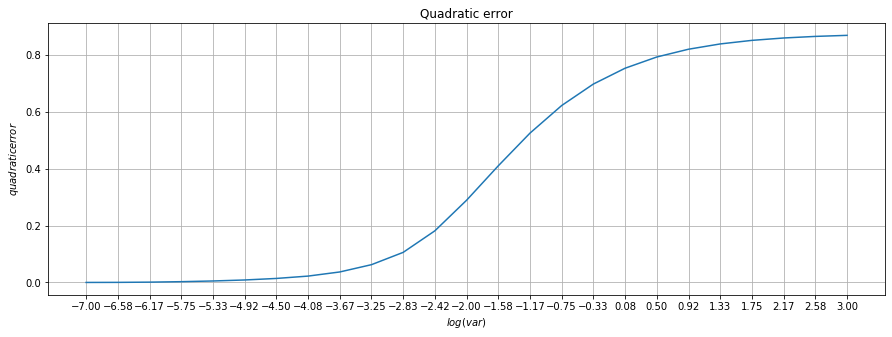

In [34]:
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(logVarList)

plt.plot((logVarList), errList)
plt.title('Quadratic error')
plt.xlabel('$log(var)$')
plt.ylabel('$quadratic error$')
plt.grid()
plt.show()

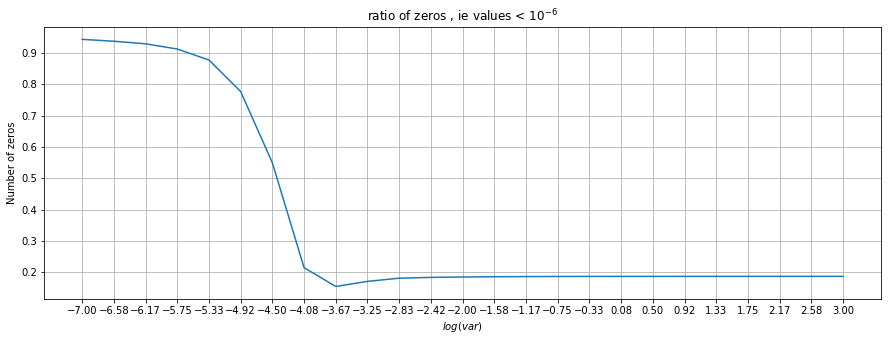

In [35]:
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(logVarList)
plt.plot((logVarList), countList)
plt.title('ratio of zeros , ie values < $10^{-6}$')
plt.xlabel('$log(var)$')
plt.ylabel('Number of zeros')
plt.grid()
plt.show()

Prendre $var=-3.67 semble être optimal. Procédons à la vérification.
Cette fois, nous sleectionnons les 10000 plus proches voisins sjitués à une distance inférieure à 0.25.

In [0]:
var = np.exp(-3.6)

In [0]:
df_approx = approx_freq(df, thresh=0.25, k=10000, var=var)

In [38]:
count_zeros(df_approx["Freq_sinistre"])

0.0901430733250791

In [39]:
err = np.sqrt(np.mean((df["Freq_sinistre"]-df_approx["Freq_sinistre"])**2))
err

0.04796854423299092